In [139]:
import qiskit
import pytket
import numpy as np
from qiskit import QuantumCircuit
from qiskit import qasm2
from pytket.passes import FullPeepholeOptimise
import pennylane as qml

import cirq.testing
from qiskit.circuit.library import UnitaryGate
import cirq


In [ ]:
def tket_to_qiskit(circ: pytket.Circuit) -> qiskit.QuantumCircuit:
    return qiskit.QuantumCircuit.from_qasm_str(pytket.qasm.circuit_to_qasm_str(circ))
def qiskit_to_tket(circ: qiskit.QuantumCircuit) -> pytket.Circuit:
    return pytket.qasm.circuit_from_qasm_str(qasm2.dumps(circ))
def qc_to_unitary(qc: qiskit.QuantumCircuit) -> np.ndarray:
    from qiskit.quantum_info import Operator
    return Operator(qc.reverse_bits()).data
def tket_pass(circ: qiskit.QuantumCircuit, preserve_topo : bool = True) -> qiskit.QuantumCircuit:
    circ = qiskit_to_tket(circ)
    FullPeepholeOptimise(allow_swaps=not preserve_topo).apply(circ)
    return tket_to_qiskit(circ)


def qiskit_O3(circ: qiskit.QuantumCircuit) -> qiskit.QuantumCircuit:
    from itertools import combinations
    circ = qiskit.transpile(circ, optimization_level=3, basis_gates=['u1', 'u2', 'u3', 'cx'])
    return circ



Pattern 1: CNOT-Exchange-X

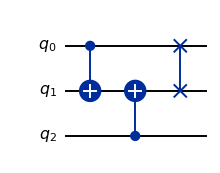

In [69]:
qc = QuantumCircuit(3)
qc.cx(0, 1)
qc.cx(2, 1)
qc.swap(0, 1)
qc.draw('mpl', scale=0.7)

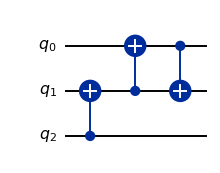

In [70]:
tket_pass(qc).draw('mpl', scale=0.7)

Pattern 2: CNOT-Exchange-Z

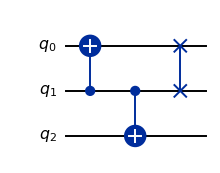

In [77]:
qc = QuantumCircuit(3)
qc.cx(1, 0)
qc.cx(1, 2)
qc.swap(0, 1)
qc.draw('mpl', scale=0.7)

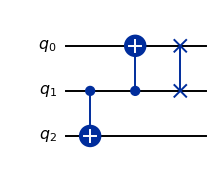

In [93]:
qc_ = QuantumCircuit(3)
qc_.cx(1, 2)
qc_.cx(1, 0)
qc_.swap(0, 1)
qc_.draw('mpl', scale=0.7)

Pattern 3: CNOT-Ladder-L

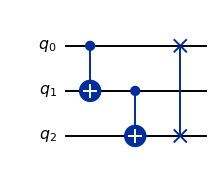

In [141]:
qc = QuantumCircuit(3)
# qc.append(UnitaryGate(cirq.testing.random_unitary(4), label='SU(4)'), [0, 2])
qc.cx(0,1)
qc.cx(1,2)
qc.swap(0,2)
qc.draw('mpl', scale=0.7)

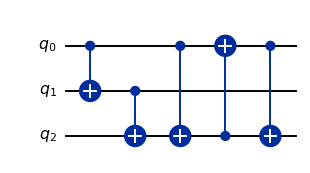

In [142]:
# Generally, 不能被简化
tket_pass(qc).draw('mpl', scale=0.7)

In [149]:
circ = qml.tape.QuantumScript([
    qml.CNOT((1, 2)),
    qml.CNOT((2, 3)),
    qml.SWAP((1, 3)),
], [])

print(qml.drawer.tape_text(circ, show_all_wires=True))

1: ─╭●────╭SWAP─┤  
2: ─╰X─╭●─│─────┤  
3: ────╰X─╰SWAP─┤  


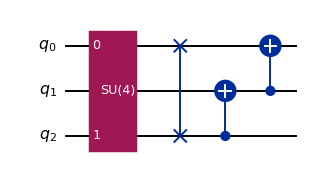

In [133]:
# 但是有两个其他的优化点

# 1) qubit dependency is all2all，所以当前面再有其他的 q0 <-> q2 两比特门的话，把 SWAP bypass 过去
qc1 = QuantumCircuit(3)
qc1.append(UnitaryGate(cirq.testing.random_unitary(4), label='SU(4)'), [0, 2])
qc1.swap(0, 2)
qc1.cx(2,1)
qc1.cx(1,0)
qc1.draw('mpl', scale=0.7)

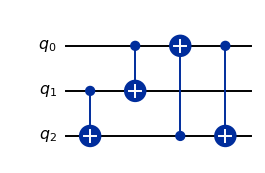

In [134]:
# 2) 利用 CNOT ladder 变换关系，把 SWAP 开销降低成 iSWAP 开销


qc2 = QuantumCircuit(3)
qc2.cx(1,2)
qc2.cx(0,1)

qc2.cx(2, 0)
qc2.cx(0, 2)

qc2.draw('mpl', scale=0.7)

In [ ]:
qc_to_unitary(qc).real

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.]])

In [128]:
qc_to_unitary(qc2).real == qc_to_unitary(qc).real

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

Pattern 3: CNOT-Ladder-R

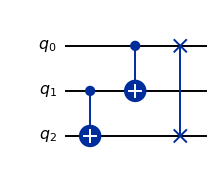

In [135]:
qc = QuantumCircuit(3)
qc.cx(1,2)
qc.cx(0,1)
qc.swap(0,2)
qc.draw('mpl', scale=0.7)

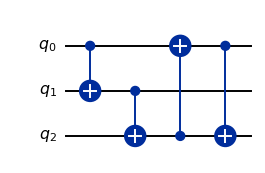

In [138]:
# 2) 利用 CNOT ladder 变换关系，把 SWAP 开销降低成 iSWAP 开销

qc2 = QuantumCircuit(3)
qc2.cx(0,1)
qc2.cx(1,2)

qc2.cx(2, 0)
qc2.cx(0, 2)

qc2.draw('mpl', scale=0.7)